In [1]:
!pip install git+https://github.com/openopt/copt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openopt/copt.git to /tmp/pip-req-build-s8n2oq2d
  Running command git clone -q https://github.com/openopt/copt.git /tmp/pip-req-build-s8n2oq2d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copt as cp
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from time import time

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
plt.style.use('seaborn')

In [8]:
np.random.seed(0)

grads = []
def callbackGrad(x, grads):
  grads.append(x['grad'])
  return True


datasets = [
    ("Gisette", cp.datasets.load_gisette, 6e3),
    ("RCV1", cp.datasets.load_rcv1, 2e4),
    ("Madelon", cp.datasets.load_madelon, 20.0),
    ("Covtype", cp.datasets.load_covtype, 200.0),
]


variants_fw = [
    "backtracking",
    "DR",
    "sublinear"]

In [4]:
def armijo_step_size(x):
    inequality_satisfied = True
    step_size_t = 1
    f_grad = copt.utils.build_func_grad(x['jac'], x['fun'], x['args'], x['eps'])
    current_grad = f_grad(x['x'])[1]

    while inequality_satisfied:
      f_next, grad_next = f_grad(x['x'] - step_size_t * x['update_direction'])


      if f_grad(x['x'] + step_size_t * x['update_direction'])[0] <= x['f_t'] + step_size_t * c1 * current_grad.dot(x['update_direction']):
        break
      else:
        step_size_t = step_size_t/2
    return step_size_t

In [7]:
datasets = [
    ("Madelon", cp.datasets.load_madelon, 20.0)
]


c1s = [0.001, 0.01, 0.1, 0.3]
dataset_grads = {}

for dataset_title, load_data, alpha in datasets:
    plt.figure()
    print("Running on the %s dataset" % dataset_title)

    X, y = load_data()
    n_samples, n_features = X.shape

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.LogLoss(X, y)
    x0 = np.zeros(n_features)
    step_dict_grads = {}
    grads = []
    for c1 in tqdm(c1s):
        grads=[]
        sol = cp.minimize_frank_wolfe(
            f.f_grad, x0, l1_ball.lmo, callback=lambda x: callbackGrad(x, grads), step=armijo_step_size, lipschitz=f.lipschitz, 
        )
        step_dict_grads[c1] = grads
    dataset_grads[dataset_title] = step_dict_grads    

Running on the Madelon dataset


100%|██████████| 4/4 [05:00<00:00, 75.13s/it]


<Figure size 576x396 with 0 Axes>

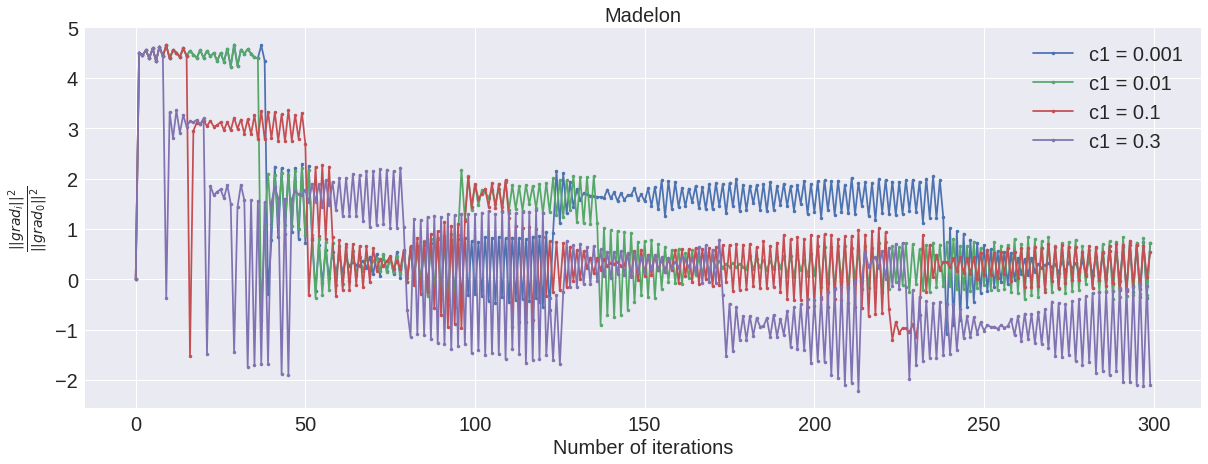

In [8]:
for dataset in dataset_grads.keys():
  plt.figure(figsize=(20,7))

  for c in dataset_grads[dataset].keys():
    # if step != 'backtracking':
    grads = np.linalg.norm(np.array(dataset_grads[dataset_title][c]), axis=1) ** 2
    plt.plot(np.log(grads[:300] / grads[0]), label = f'c1 = {c}', marker='.')

  plt.xlabel('Number of iterations',  fontsize=20)
  plt.ylabel(r'$\frac{||grad_i||^2}{||grad_0||^2}$', fontsize=20)
  plt.title(dataset,  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(dataset+'.png')

In [5]:
datasets = [
    ("Madelon", cp.datasets.load_madelon, 20.0)
]


c1s = [0.001, 0.01, 0.1, 0.3]
dataset_vals_a = {}

for dataset_title, load_data, alpha in datasets:
    print("Running on the %s dataset" % dataset_title)

    X, y = load_data()
    n_samples, n_features = X.shape

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.LogLoss(X, y)
    x0 = np.zeros(n_features)
    step_dict_vals_a = {}
    for c1 in tqdm(c1s):
        cb = cp.utils.Trace(f)
        sol = cp.minimize_frank_wolfe(
            f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, 
        )
        step_dict_vals_a[c1] = cb.trace_fx
    dataset_vals_a[dataset_title] = step_dict_vals_a    

Running on the Madelon dataset
madelon dataset is not present in the folder /root/copt_data/madelon. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/madelon/X_train.indptr.npy
Extracting data to /root/copt_data/madelon/X_test.indptr.npy
Extracting data to /root/copt_data/madelon/y_test.npy
Extracting data to /root/copt_data/madelon/y_train.npy
Extracting data to /root/copt_data/madelon/X_test.data.npy
Extracting data to /root/copt_data/madelon/X_train.indices.npy
Extracting data to /root/copt_data/madelon/X_train.data.npy
Extracting data to /root/copt_data/madelon/X_test.indices.npy


100%|██████████| 4/4 [04:51<00:00, 72.91s/it]


<Figure size 576x396 with 0 Axes>

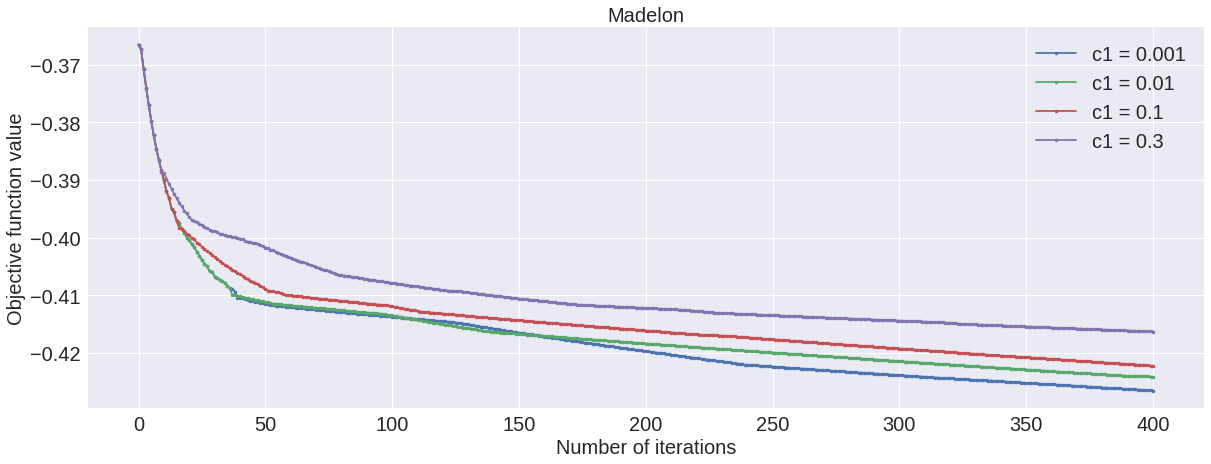

In [6]:
for dataset in dataset_vals_a.keys():
  plt.figure(figsize=(20,7))

  for c in dataset_vals_a[dataset].keys():
    # if step != 'backtracking':
    plt.plot(np.log(dataset_vals_a[dataset_title][c]), label = f'c1 = {c}', marker='.')

  plt.xlabel('Number of iterations',  fontsize=20)
  plt.ylabel('Objective function value', fontsize=20)
  plt.title(dataset,  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(dataset+'.png')

In [5]:
from sklearn import datasets

n = 5000
n_samples, n_features = n, n
A, b, coef = datasets.make_regression(n, n, coef=True)
alpha = .5 * n_features
 
X, y = A, b
 
l1_ball = copt.constraint.L1Ball(alpha)
f = copt.loss.SquareLoss(X, y)

In [6]:
c1s = [0.001, 0.01, 0.1, 0.3]

x0 = np.zeros(n_features)
step_dict_grads = {}
grads = []
for c1 in tqdm(c1s):
    grads=[]
    sol = cp.minimize_frank_wolfe(
        f.f_grad, x0, l1_ball.lmo, callback=lambda x: callbackGrad(x, grads), step=armijo_step_size, lipschitz=f.lipschitz, 
    )
    step_dict_grads[c1] = grads

100%|██████████| 4/4 [1:52:54<00:00, 1693.64s/it]


In [7]:
step_dict_vals_ss = {}
for c1 in tqdm(c1s):
    cb = cp.utils.Trace(f)
    sol = cp.minimize_frank_wolfe(
        f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, 
    )
    step_dict_vals_ss[c1] = cb.trace_fx

100%|██████████| 4/4 [1:56:06<00:00, 1741.52s/it]


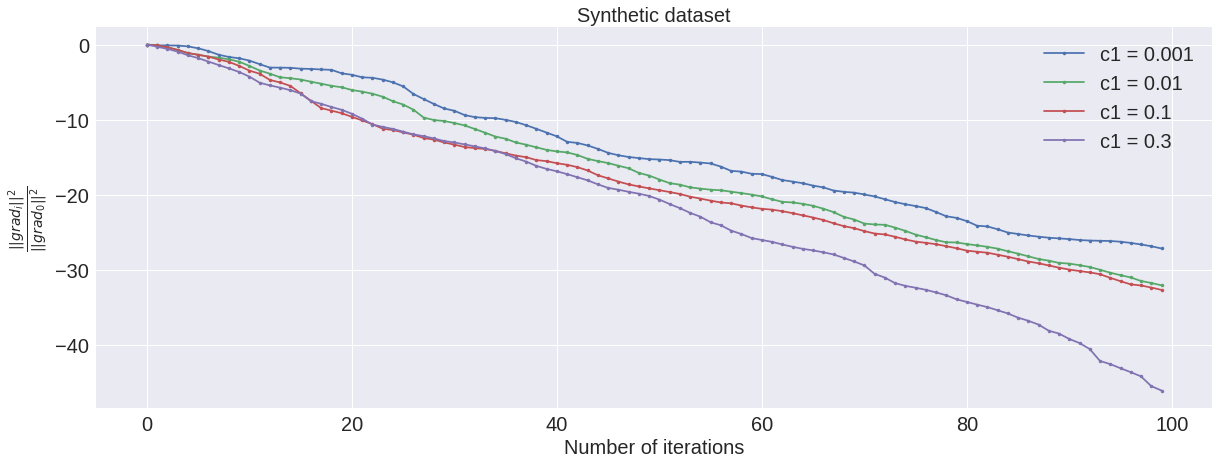

In [8]:
plt.figure(figsize=(20,7))

for c in step_dict_grads.keys():
  # if step != 'backtracking':
  grads = np.linalg.norm(np.array(step_dict_grads[c]), axis=1) ** 2
  plt.plot(np.log(grads[:100] / grads[0]), label = f'c1 = {c}', marker='.')

plt.xlabel('Number of iterations',  fontsize=20)
plt.ylabel(r'$\frac{||grad_i||^2}{||grad_0||^2}$', fontsize=20)
plt.title('Synthetic dataset',  fontsize=20)
plt.legend(fontsize=20, loc=1)
plt.tick_params(labelsize=20)
plt.savefig('armijo_synthetic.png')


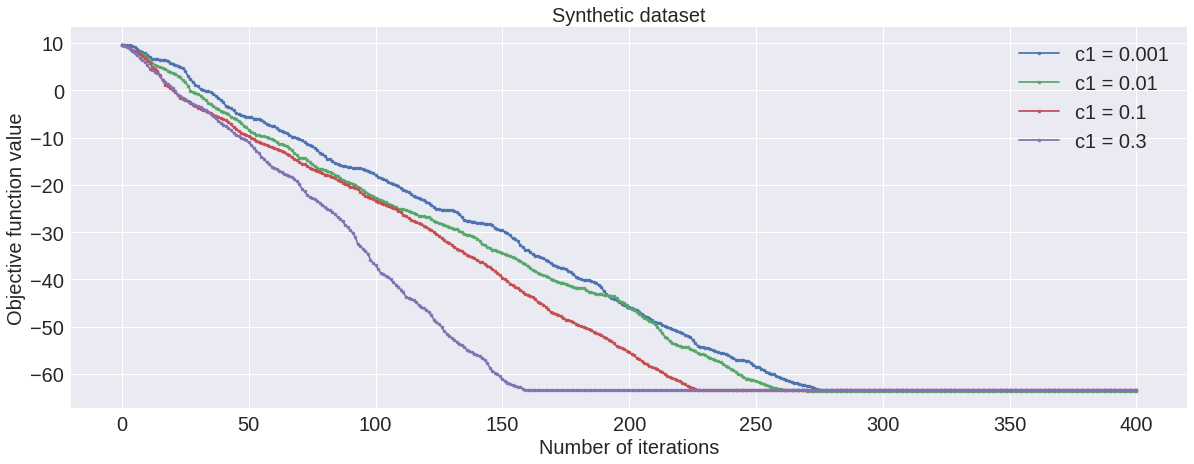

In [12]:
plt.figure(figsize=(20,7))

for c in step_dict_vals_ss.keys():
  # if step != 'backtracking':
  plt.plot(np.log(step_dict_vals_ss[c]), label = f'c1 = {c}', marker='.')

plt.xlabel('Number of iterations',  fontsize=20)
plt.ylabel('Objective function value', fontsize=20)
plt.title('Synthetic dataset',  fontsize=20)
plt.legend(fontsize=20, loc=1)
plt.tick_params(labelsize=20)
plt.savefig('armijo_synthetic.png')


# Objective fucntion value VS time

In [9]:
datasets = [
    ("Gisette", cp.datasets.load_gisette, 6e3),
    ("RCV1", cp.datasets.load_rcv1, 2e4),
    ("Madelon", cp.datasets.load_madelon, 20.0),
    ("Covtype", cp.datasets.load_covtype, 200.0),
]


variants_fw = [
    "backtracking",
    "DR",
    "sublinear"]

dataset_vals = {}
dataset_times = {}
c1=0.1
for dataset_title, load_data, alpha in datasets:
    plt.figure()
    print("Running on the %s dataset" % dataset_title)

    X, y = load_data()
    n_samples, n_features = X.shape

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.LogLoss(X, y)
    x0 = np.zeros(n_features)

    step_vals ={}
    step_times = {}
    for step in tqdm(variants_fw):
        cb = cp.utils.Trace(f)
        sol = cp.minimize_frank_wolfe(
            f.f_grad, x0, l1_ball.lmo, callback=cb, step=step, lipschitz=f.lipschitz, max_iter=400
        )
        step_vals[step] = cb.trace_fx
        step_times[step] = cb.trace_time

    cb = cp.utils.Trace(f)
    sol = cp.minimize_frank_wolfe(
        f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, max_iter=400
    )
    step_vals['armijo'] = cb.trace_fx
    step_times['armijo'] = cb.trace_time


    dataset_vals[dataset_title] = step_vals
    dataset_times[dataset_title] = step_times


Running on the Gisette dataset
gisette dataset is not present in the folder /root/copt_data/gisette. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/gisette/X_test.indptr.npy
Extracting data to /root/copt_data/gisette/y_train.npy
Extracting data to /root/copt_data/gisette/X_test.data.npy
Extracting data to /root/copt_data/gisette/X_train.indptr.npy
Extracting data to /root/copt_data/gisette/y_test.npy
Extracting data to /root/copt_data/gisette/X_train.data.npy
Extracting data to /root/copt_data/gisette/X_train.indices.npy
Extracting data to /root/copt_data/gisette/X_test.indices.npy


100%|██████████| 3/3 [03:36<00:00, 72.14s/it]


Running on the RCV1 dataset
rcv1 dataset is not present in the folder /root/copt_data/rcv1. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/rcv1/X_test.indptr.npy
Extracting data to /root/copt_data/rcv1/y_train.npy
Extracting data to /root/copt_data/rcv1/X_test.data.npy
Extracting data to /root/copt_data/rcv1/X_train.indptr.npy
Extracting data to /root/copt_data/rcv1/y_test.npy
Extracting data to /root/copt_data/rcv1/X_train.data.npy
Extracting data to /root/copt_data/rcv1/X_train.indices.npy
Extracting data to /root/copt_data/rcv1/X_test.indices.npy


100%|██████████| 3/3 [10:41<00:00, 213.84s/it]


Running on the Madelon dataset


100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


Running on the Covtype dataset
covtype dataset is not present in the folder /root/copt_data/covtype. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/covtype/y_train.npy
Extracting data to /root/copt_data/covtype/X_train.indptr.npy
Extracting data to /root/copt_data/covtype/X_train.data.npy
Extracting data to /root/copt_data/covtype/X_train.indices.npy


100%|██████████| 3/3 [02:31<00:00, 50.48s/it]


<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

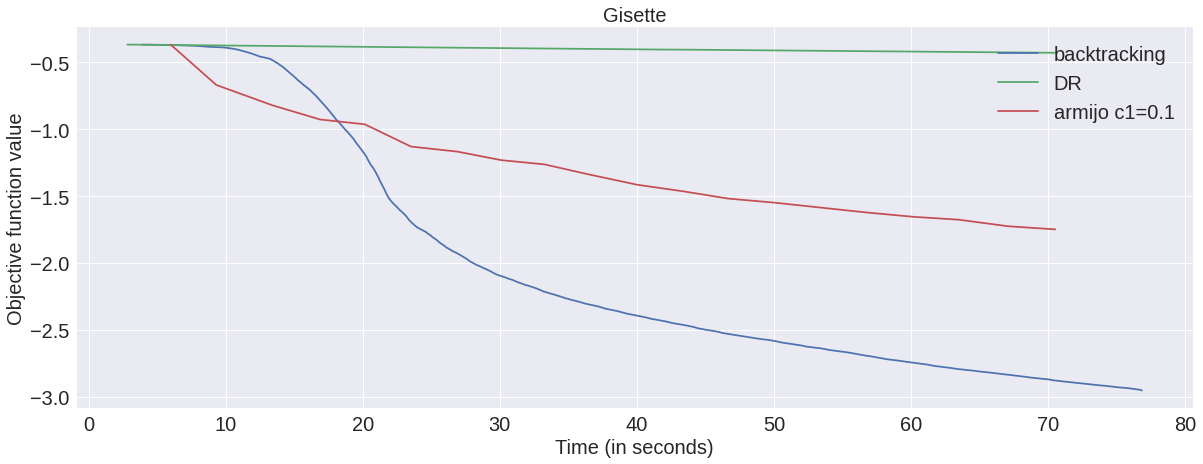

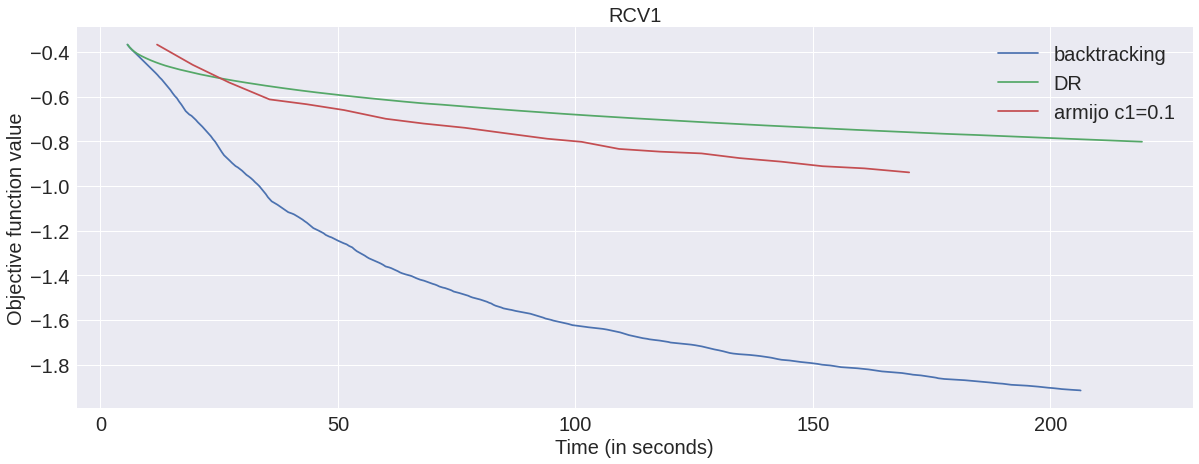

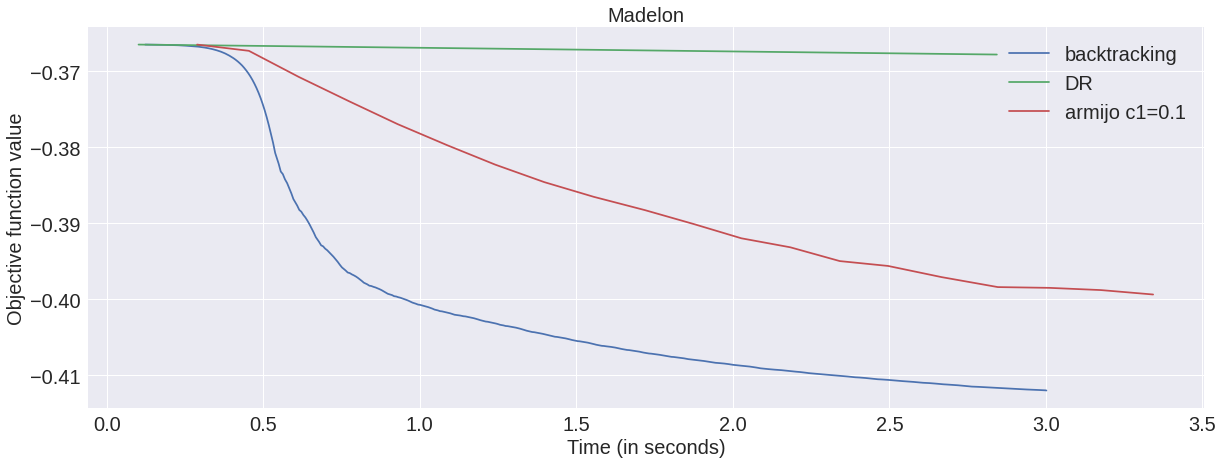

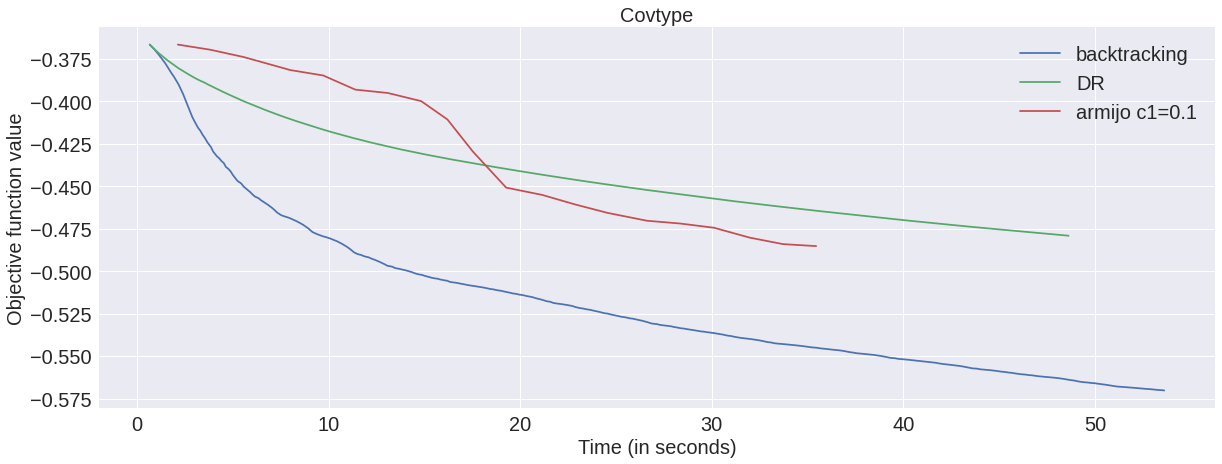

In [12]:
for dataset in dataset_vals.keys():
  plt.figure(figsize=(20,7))

  for step in dataset_vals[dataset].keys():
    # if step != 'backtracking':
    if step == 'armijo':
      plt.plot(dataset_times[dataset][step][:20], np.log(dataset_vals[dataset][step][:20]), label = f'{step} c1=0.1' )
    elif step != 'sublinear':
      plt.plot(dataset_times[dataset][step], np.log(dataset_vals[dataset][step]), label = step)
    
  plt.xlabel('Time (in seconds)',  fontsize=20)
  plt.ylabel(r'Objective function value', fontsize=20)
  plt.title(dataset,  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(dataset+'.png')
  plt.show()

Gisette
backtracking: value: 0.052193494792166326 time: 76.829371
DR: value: 0.6519526429397117 time: 70.490875
sublinear: value: 11.453374545417189 time: 69.078115
armijo: value: 0.015530071723700372 time: 1488.03039


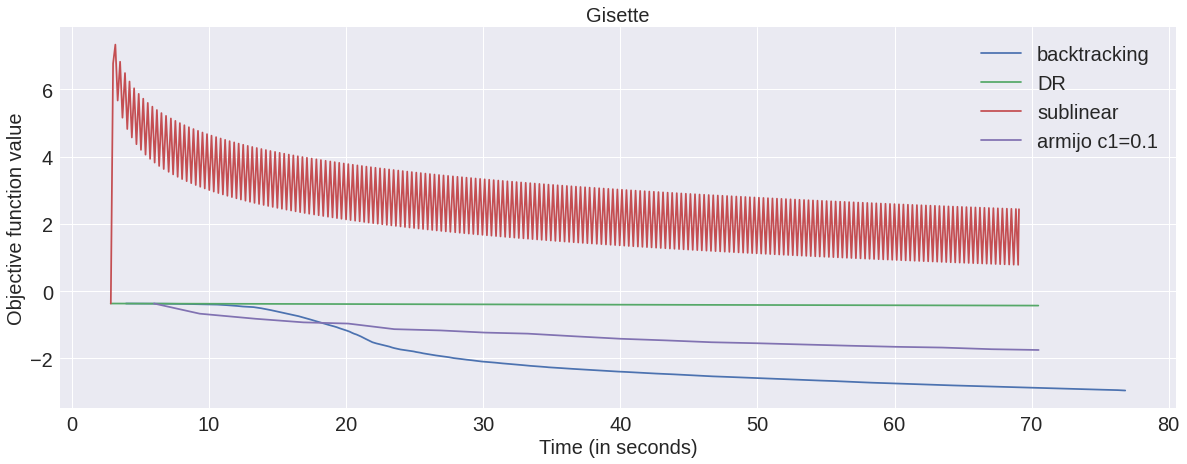

RCV1
backtracking: value: 0.14722000617032688 time: 206.345875
DR: value: 0.4486058214894085 time: 219.258683
sublinear: value: 0.7766546047799608 time: 215.908357
armijo: value: 0.12803678920833356 time: 3771.22678


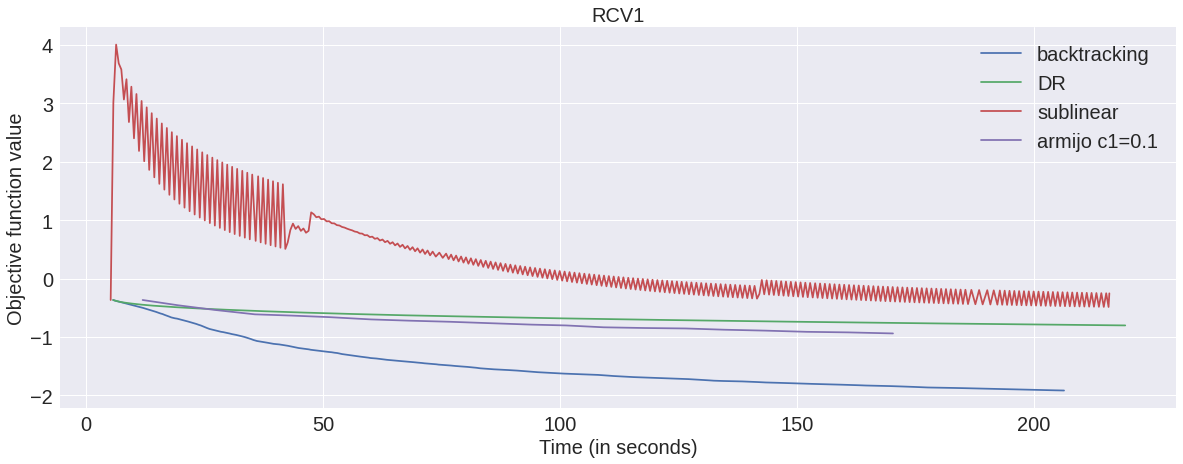

Madelon
backtracking: value: 0.6623318744052324 time: 3.001487
DR: value: 0.6922398416064116 time: 2.843205
sublinear: value: 12.665785829332034 time: 2.819351
armijo: value: 0.6555574399718158 time: 71.73848


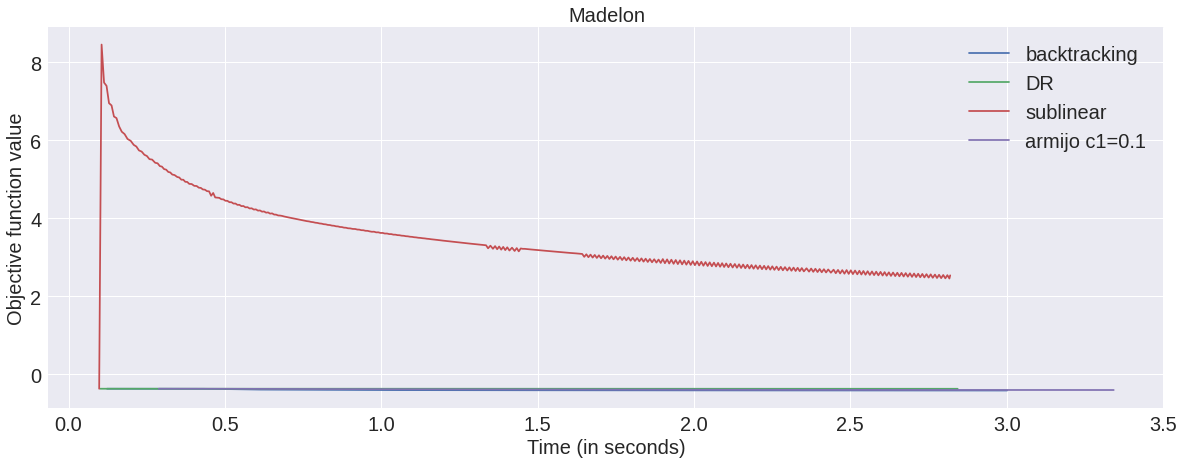

Covtype
backtracking: value: 0.5653637078324885 time: 53.606767
DR: value: 0.6192994146114554 time: 48.617024
sublinear: value: 0.7136899722272767 time: 49.197269
armijo: value: 0.51856920404252 time: 919.433088


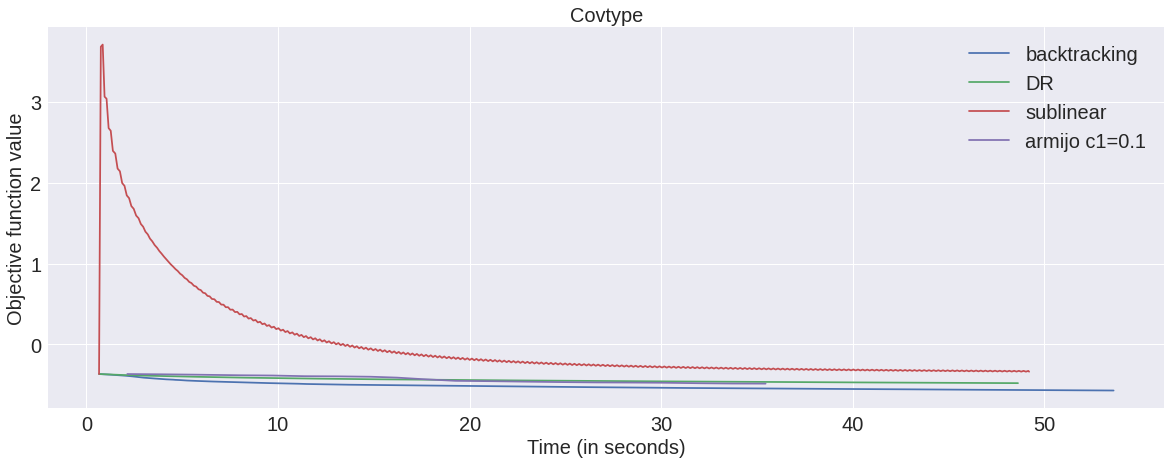

In [13]:
for dataset in dataset_vals.keys():
  plt.figure(figsize=(20,7))
  print(dataset)

  for step in dataset_vals[dataset].keys():
    # if step != 'backtracking':
    if step == 'armijo':
      plt.plot(dataset_times[dataset][step][:20], np.log(dataset_vals[dataset][step][:20]), label = f'{step} c1=0.1')
    else:
      plt.plot(dataset_times[dataset][step], np.log(dataset_vals[dataset][step]), label = step)
    print(f'{step}: value: {dataset_vals[dataset][step][-1]} time: {dataset_times[dataset][step][-1]}')
  plt.xlabel('Time (in seconds)',  fontsize=20)
  plt.ylabel(r'Objective function value', fontsize=20)
  plt.title(dataset,  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(dataset+'.png')
  plt.show()

In [6]:
#adopted from https://gist.github.com/bstellato/23322fe5d87bb71da922fbc41d658079
def create_mat(cond_num, dim):
  cond_P = cond_num
  log_cond_P = np.log(cond_P)
  exp_vec = np.arange(-log_cond_P/4., log_cond_P * (dim + 1)/(4 * (dim - 1)), log_cond_P/(2.*(dim-1)))
  s = np.exp(exp_vec[:dim])
  S = np.diag(s)
  U, _ = np.linalg.qr((np.random.rand(dim, dim) - 5.) * 200)
  V, _ = np.linalg.qr((np.random.rand(dim, dim) - 5.) * 200)
  P = U.dot(S).dot(V.T)
  P = P.dot(P.T)
  coef = np.random.randint(-10, 10, size=P.shape[1])
  b = P @ coef + np.random.randn(P.shape[0])
  return P, b

In [21]:
from sklearn import datasets

n = 5000
n_samples, n_features = n, n
alpha = .5 * n_features
synth_data_vals = {}
synth_data_times = {}


for c_num in [3000, 15000, 30000, 60000, 90000]:
  A, b = create_mat(c_num, n)
  
  X_s, y_s = A, b
  
  l1_ball = copt.constraint.L1Ball(alpha)
  f = copt.loss.SquareLoss(X_s, y_s)

  x0 = np.zeros(n_features)
  step_vals_b = {}
  step_times_b = {}
  for step in variants_fw:
      cb = cp.utils.Trace(f)
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step=step, lipschitz=f.lipschitz, max_iter=800
      )
      step_vals_b[step] = cb.trace_fx
      step_times_b[step] = cb.trace_time

  cb = cp.utils.Trace(f)
  sol = cp.minimize_frank_wolfe(
      f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, max_iter=800
  )
  step_vals_b['armijo'] = cb.trace_fx
  step_times_b['armijo'] = cb.trace_time  

  synth_data_vals[c_num] = step_vals_b
  synth_data_times[c_num] = step_times_b




KeyboardInterrupt: ignored

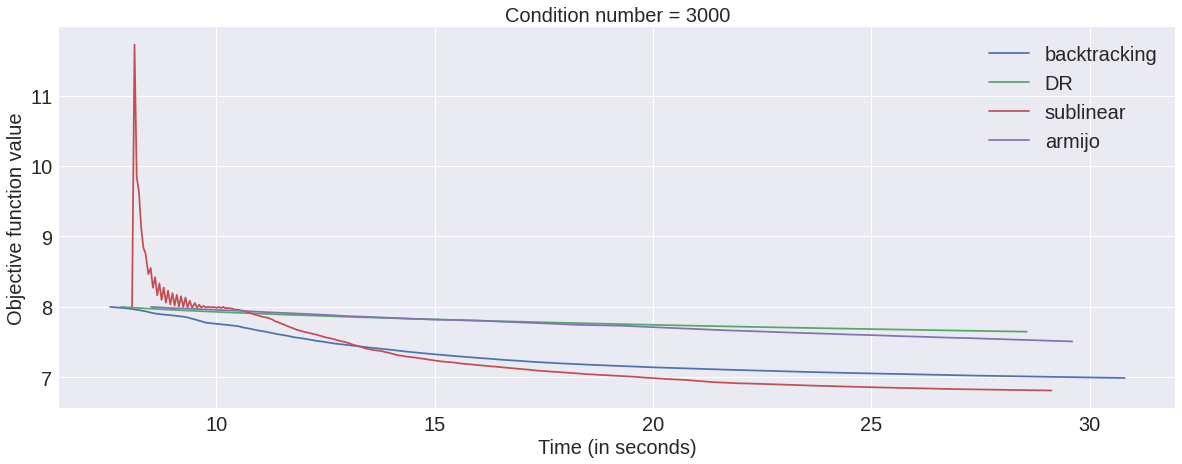

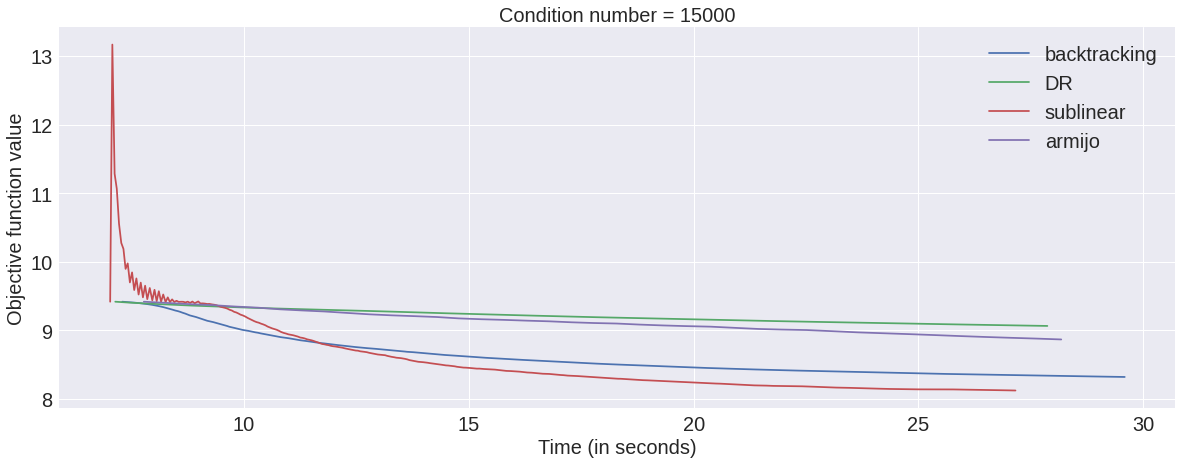

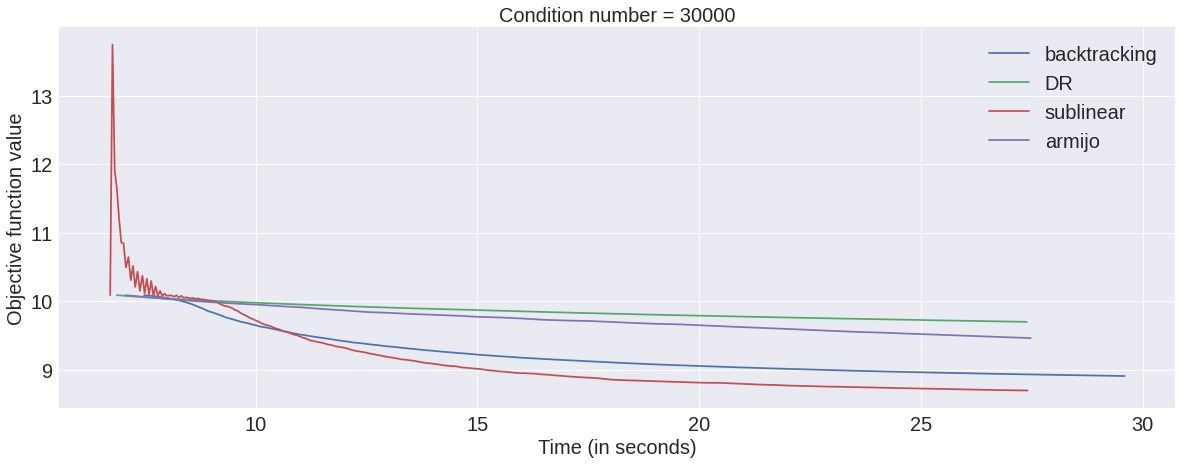

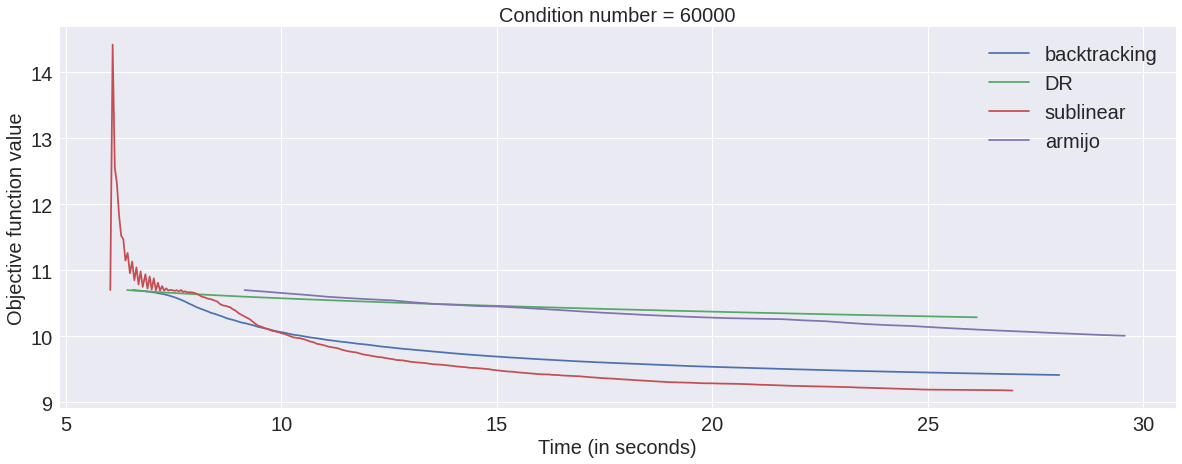

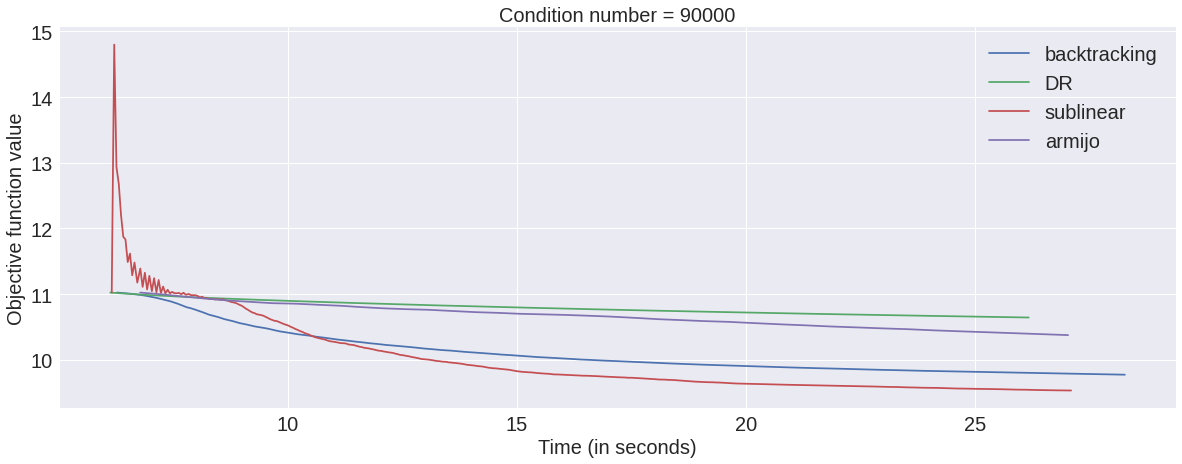

In [20]:


for c_n in synth_data_vals.keys():
  plt.figure(figsize=(20,7))
  # if step != 'backtracking':
  for step in synth_data_vals[c_n].keys():
    if step == 'armijo':
      plt.plot(synth_data_times[c_n][step][:40], np.log(synth_data_vals[c_n][step][:40]), label = step)
    else:
      plt.plot(synth_data_times[c_n][step], np.log(synth_data_vals[c_n][step]), label = step)
  # print(f'{c_n}: value: {step_vals_s[step][-1]} time: {step_times_s[step][-1]}')
  plt.xlabel('Time (in seconds)',  fontsize=20)
  plt.ylabel('Objective function value', fontsize=20)
  plt.title('Condition number = ' + str(c_n),  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(f'obj_fun_{c_n}.png')
  plt.show()

In [23]:
synth_data_vals_d = {}
synth_data_times_d = {}
c_n = 60000
for n_dim in [500, 2500, 5000, 10000]:
  A, b = create_mat(c_n, n_dim)
  alpha = .5 * n_dim
  X_s, y_s = A, b
  l1_ball = copt.constraint.L1Ball(alpha)
  f = copt.loss.SquareLoss(X_s, y_s)

  x0 = np.zeros(n_dim)
  step_vals_b = {}
  step_times_b = {}
  for step in tqdm(variants_fw):
      cb = cp.utils.Trace(f)
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step=step, lipschitz=f.lipschitz, max_iter=400
      )
      step_vals_b[step] = cb.trace_fx
      step_times_b[step] = cb.trace_time

  cb = cp.utils.Trace(f)
  sol = cp.minimize_frank_wolfe(
      f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, max_iter=400
  )
  step_vals_b['armijo'] = cb.trace_fx
  step_times_b['armijo'] = cb.trace_time  

  synth_data_vals_d[n_dim] = step_vals_b
  synth_data_times_d[n_dim] = step_times_b




100%|██████████| 3/3 [05:48<00:00, 116.15s/it]


60000: step: backtracking value: 0.2726 time: 12060.526925835204
60000: step: DR value: 0.257364 time: 18568.456263150936
60000: step: sublinear value: 0.619878 time: 11305.958546427346
60000: step: armijo value: 2.894069 time: 11451.383000010768


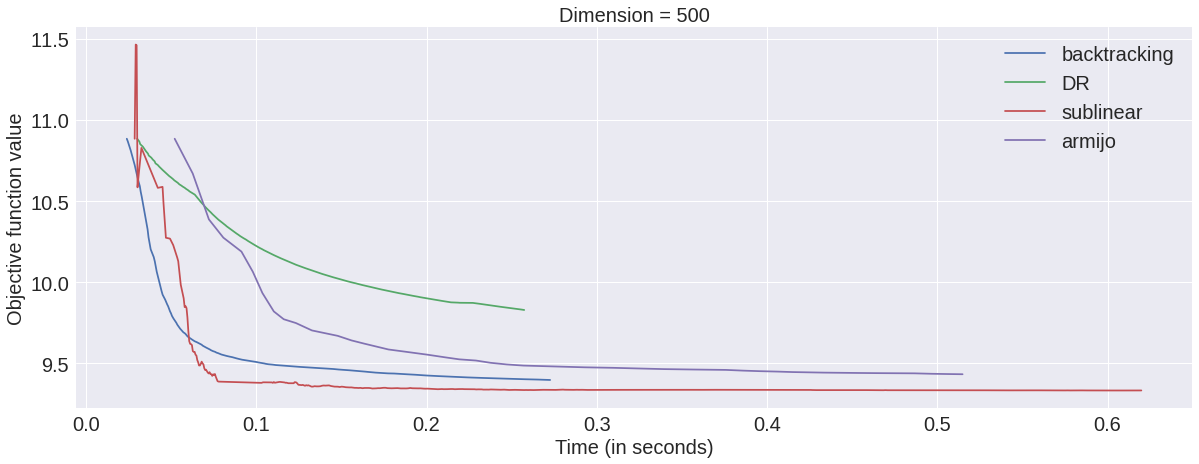

60000: step: backtracking value: 5.698817 time: 14045.801192979148
60000: step: DR value: 5.262253 time: 29045.06131114903
60000: step: sublinear value: 5.247165 time: 11912.626130113402
60000: step: armijo value: 58.085879 time: 12146.288699751633


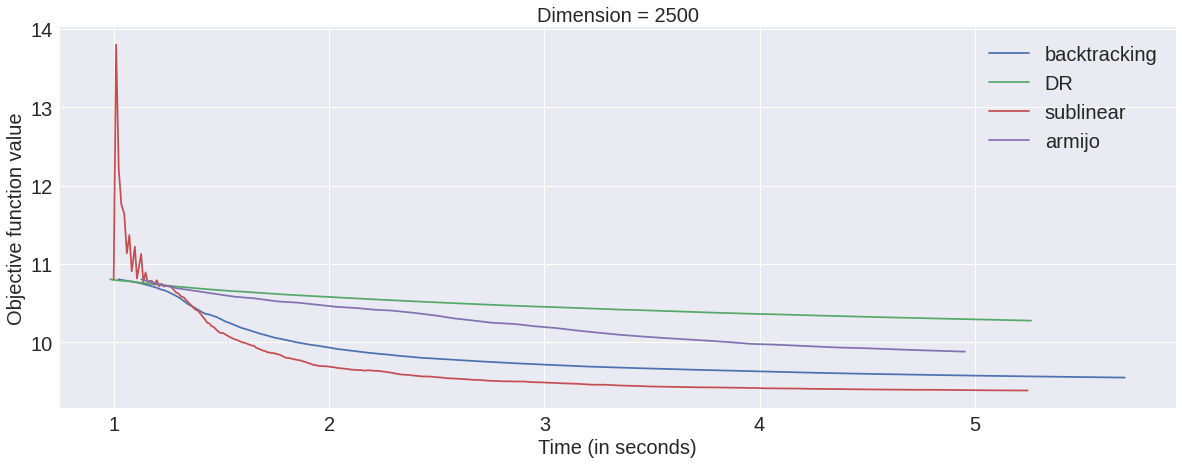

60000: step: backtracking value: 29.026186 time: 14833.19440019014
60000: step: DR value: 26.506555 time: 33985.8291940923
60000: step: sublinear value: 26.710469 time: 12063.81401544826
60000: step: armijo value: 271.928407 time: 11944.910997922936


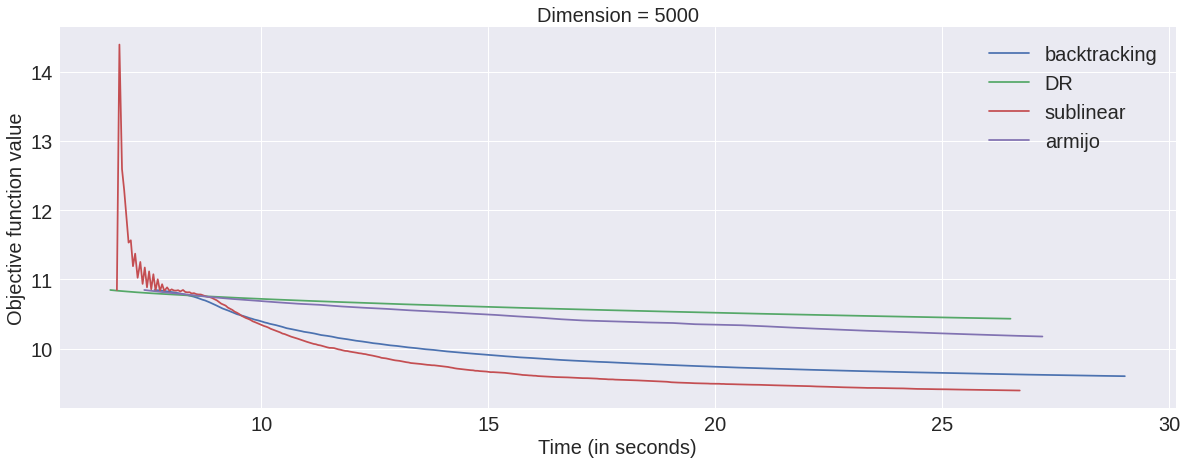

60000: step: backtracking value: 119.829579 time: 14701.572654433256
60000: step: DR value: 114.393097 time: 32381.440449163132
60000: step: sublinear value: 114.221104 time: 12417.821120440065
60000: step: armijo value: 1067.418132 time: 11258.060323071384


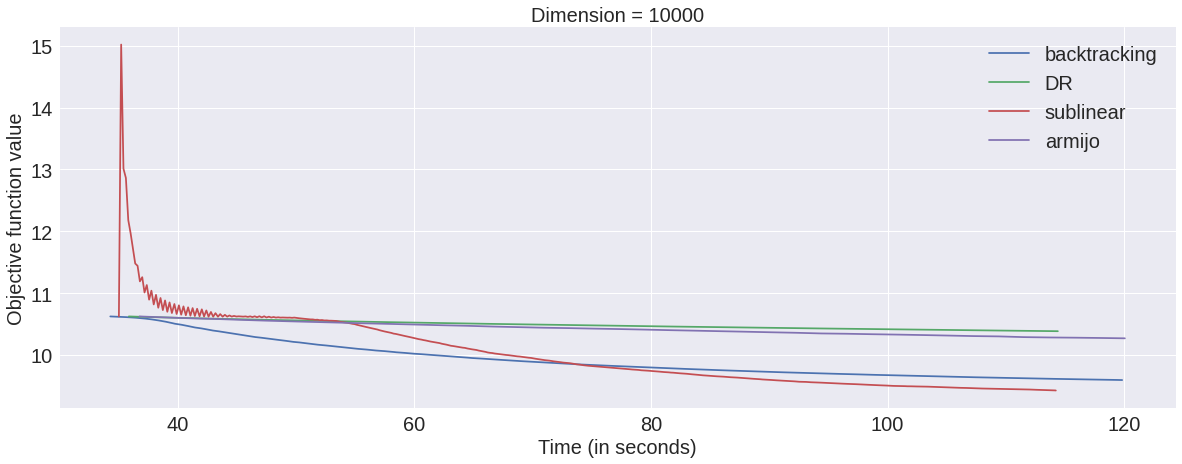

In [24]:
for n_dim in synth_data_vals_d.keys():
  plt.figure(figsize=(20,7))
  # if step != 'backtracking':
  for step in synth_data_vals_d[n_dim].keys():
    if step == 'armijo':
      plt.plot(synth_data_times_d[n_dim][step][:40], np.log(synth_data_vals_d[n_dim][step][:40]), label = step)
    else:
      plt.plot(synth_data_times_d[n_dim][step], np.log(synth_data_vals_d[n_dim][step]), label = step)
    print(f'{c_n}: step: {step} value: {synth_data_times_d[n_dim][step][-1]} time: {synth_data_vals_d[n_dim][step][-1]}')
  plt.xlabel('Time (in seconds)',  fontsize=20)
  plt.ylabel('Objective function value', fontsize=20)
  plt.title('Dimension = ' + str(n_dim),  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(f'obj_fun_{c_n}.png')
  plt.show()

In [19]:
synth_data_vals_d = {}
synth_data_times_d = {}
c_n = 5000
c1 = 0.1
for n_dim in [500, 2500, 5000, 10000]:
  A, b = create_mat(c_n, n_dim)
  alpha = .5 * n_dim
  X_s, y_s = A, b
  l1_ball = copt.constraint.L1Ball(alpha)
  f = copt.loss.SquareLoss(X_s, y_s)

  x0 = np.zeros(n_dim)
  step_vals_b = {}
  step_times_b = {}
  for step in tqdm(variants_fw):
      cb = cp.utils.Trace(f)
      sol = cp.minimize_frank_wolfe(
          f.f_grad, x0, l1_ball.lmo, callback=cb, step=step, lipschitz=f.lipschitz, max_iter=800
      )
      step_vals_b[step] = cb.trace_fx
      step_times_b[step] = cb.trace_time

  cb = cp.utils.Trace(f)
  sol = cp.minimize_frank_wolfe(
      f.f_grad, x0, l1_ball.lmo, callback=cb, step=armijo_step_size, lipschitz=f.lipschitz, max_iter=800
  )
  step_vals_b['armijo'] = cb.trace_fx
  step_times_b['armijo'] = cb.trace_time  

  synth_data_vals_d[n_dim] = step_vals_b
  synth_data_times_d[n_dim] = step_times_b




100%|██████████| 3/3 [10:03<00:00, 201.21s/it]


5000: step: backtracking value: 0.540573 time: 1647.6352876146593
5000: step: DR value: 0.508717 time: 2039.185075363692
5000: step: sublinear value: 0.454066 time: 1607.3051692754416
5000: step: armijo value: 4.829336 time: 1616.3688533841605


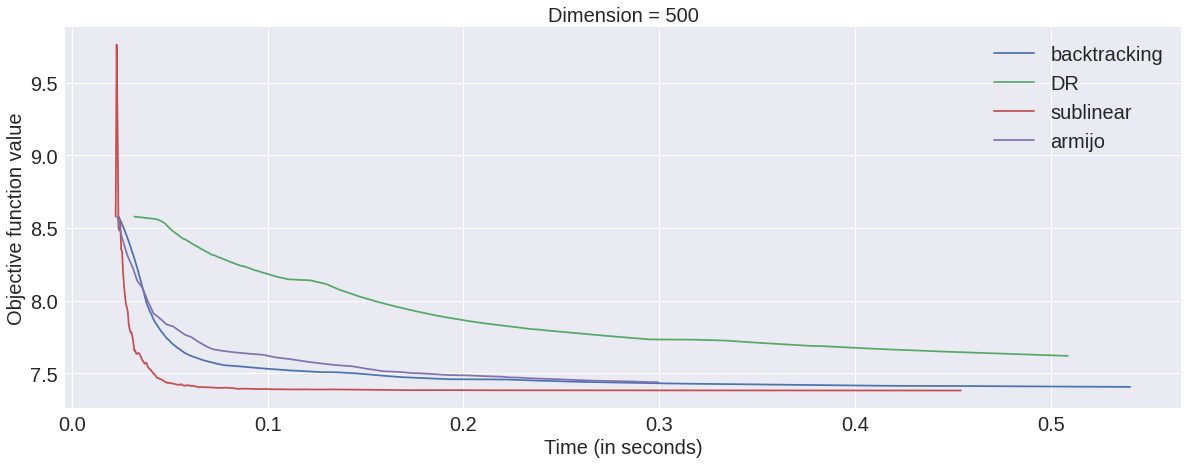

5000: step: backtracking value: 10.287987 time: 1435.2085118405598
5000: step: DR value: 10.307608 time: 2423.63526398012
5000: step: sublinear value: 10.182954 time: 1298.6558204787336
5000: step: armijo value: 119.157579 time: 1317.7305395927106


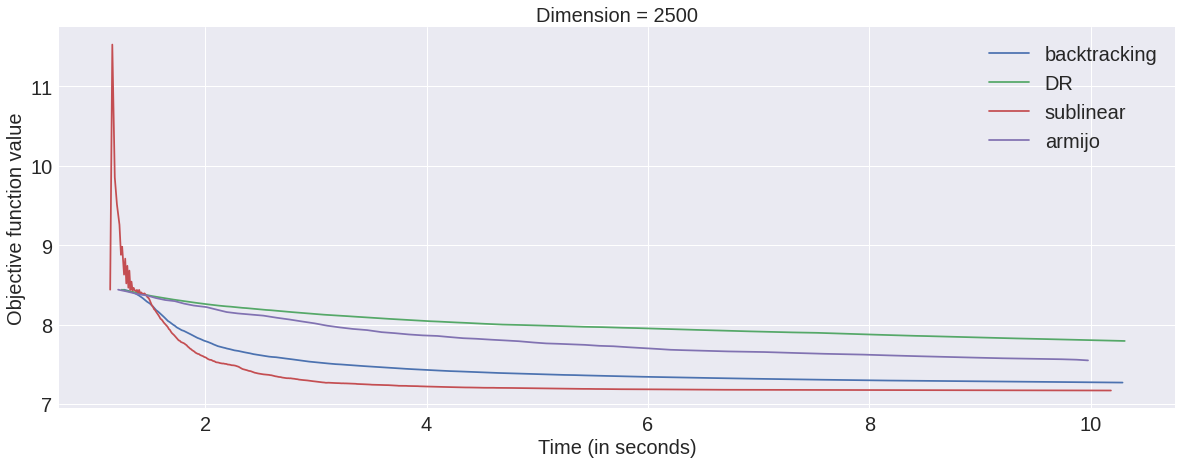

5000: step: backtracking value: 48.736239 time: 1533.0942543231076
5000: step: DR value: 45.693646 time: 2856.6013948989057
5000: step: sublinear value: 45.291002 time: 1326.6438247559595
5000: step: armijo value: 567.538281 time: 1335.720715142695


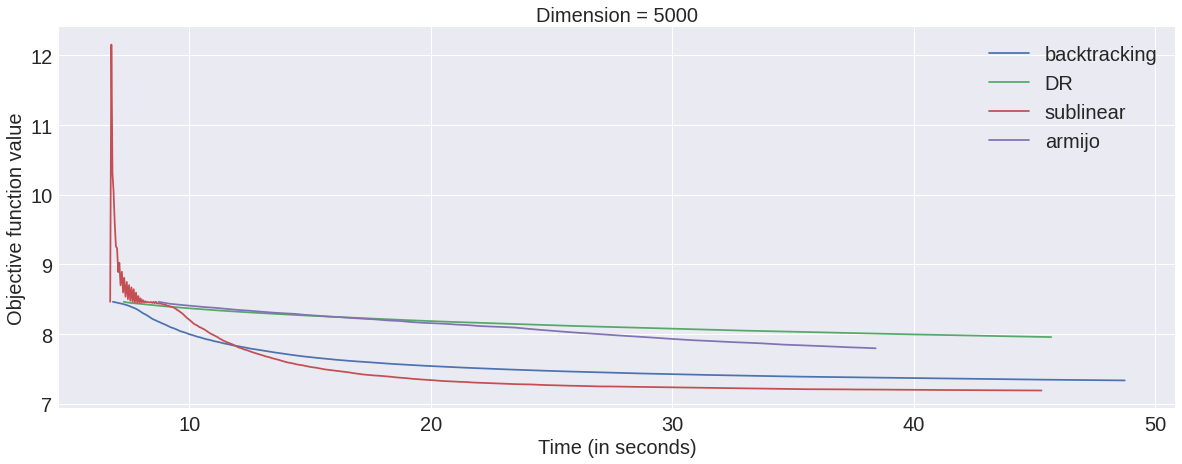

5000: step: backtracking value: 209.801202 time: 1888.3746994112178
5000: step: DR value: 197.658628 time: 3680.075899384132
5000: step: sublinear value: 196.172724 time: 1584.128548657309
5000: step: armijo value: 2269.695251 time: 1575.732373796349


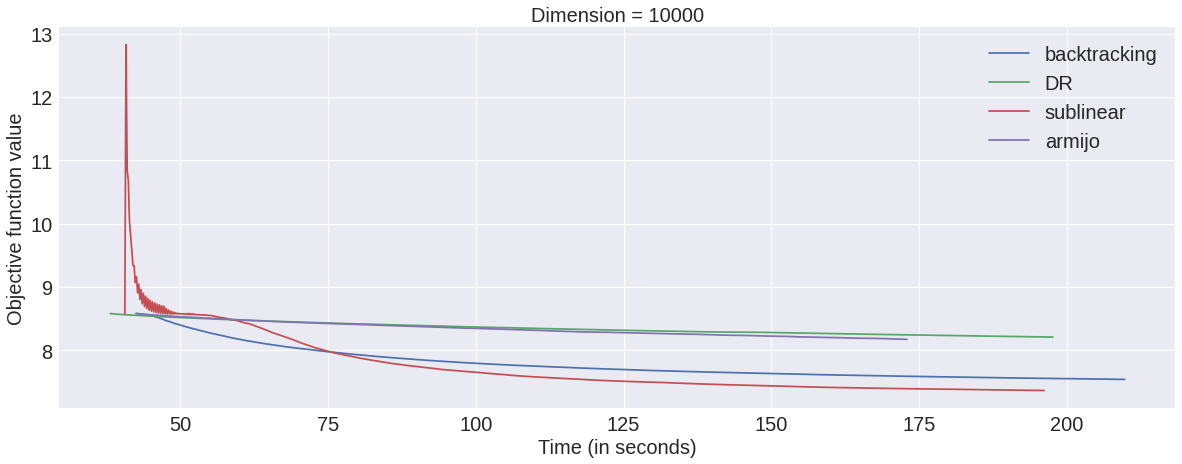

In [24]:
for n_dim in synth_data_vals_d.keys():
  plt.figure(figsize=(20,7))
  # if step != 'backtracking':
  for step in synth_data_vals_d[n_dim].keys():
    if step == 'armijo':
      plt.plot(synth_data_times_d[n_dim][step][:60], np.log(synth_data_vals_d[n_dim][step][:60]), label = step)
    else:
      plt.plot(synth_data_times_d[n_dim][step], np.log(synth_data_vals_d[n_dim][step]), label = step)
    print(f'{c_n}: step: {step} value: {synth_data_times_d[n_dim][step][-1]} time: {synth_data_vals_d[n_dim][step][-1]}')
  plt.xlabel('Time (in seconds)',  fontsize=20)
  plt.ylabel('Objective function value', fontsize=20)
  plt.title('Dimension = ' + str(n_dim),  fontsize=20)
  plt.legend(fontsize=20, loc=1)
  plt.tick_params(labelsize=20)
  plt.savefig(f'obj_fun_{c_n}.png')
  plt.show()